In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from util          import *
from basics        import *
from simulate_data import *
from estimators    import *
from config        import *
from scipy.special import *
configure_pylab()   

import jax
import jax.numpy as np
import numpy.random as npr
import numpy as np0

from jax               import jit, grad, vmap
from jax.config        import config
from jax.scipy.special import logsumexp
from jax.numpy         import *
from jax               import jacfwd, jacrev
from jax               import lax
from jax.numpy.fft     import *
from jax.numpy.linalg  import *

from scipy.linalg.lapack import dtrtri

def ltinv(ch):
    q,info = scipy.linalg.lapack.dtrtri(ch,lower=True)
    if info!=0: raise ValueError('lapack.dtrtri: '+(
            'argument %d invalid'%-info if info<0 
            else 'diagonal element %d is 0'%info))
    return q

# neuter jit for profiling
#jit = lambda x:x
    
@jit
def slog(x):
    return log(maximum(1e-10,x))
@jit
def sexp(x):
    return exp(clip(x,-10,10))
@jit
def tdivl(A,B):
    return jax.scipy.linalg.solve_triangular(A,B,lower=True)
@jit
def tdivu(A,B):
    return jax.scipy.linalg.solve_triangular(A,B,lower=False)
@jit
def chol(x):
    return jax.scipy.linalg.cholesky(x,lower=True)
@jit
def lnd(A):
    return jax.numpy.linalg.slogdet(A)[1]
@jit
def reverse(A):
    return roll(roll(A[::-1,:],1,axis=0)[:,::-1],1,axis=1)
@jit
def lndpsd(Σ):
    return 2*sum(slog(diag(chol(Σ))))
@jit
def RI(x):
    return real(x)+imag(x)

In [2]:
# These are faster
from numpy.fft import *
import pyfftw
from pyfftw.interfaces.numpy_fft import *

## Simulate grid cell data 

In [3]:
tol    = 1e-4      # Newton convergence tolerance
mintol = 1e-5      # Minimum residual tolerance
L      = 128       # Grid size
T      = L*L       # Total number of basis functions 
P      = L/5       # Grid spacing
fgσ    = P/pi      # Foreground blur
bgσ    = fgσ*5     # Background blur
α      = 0.5       # Grid "sharpness"
μ      = 1500/L**2 # Mean firing rate (spikes per sample)

mask,λ0,λ0_bg,N,K = simulate_data(L,P,α,μ)

In [10]:
# Fourier convolution
def cv(K,v):
    return real(ifft2(fft2(v.reshape(L,L),norm='ortho')*K,norm='ortho')).ravel()
def cm(K,M):
    return real(ifft2(K[:,:,None]*fft2(M.reshape(L,L,M.shape[-1]),axes=(0,1)),axes=(0,1))).reshape(T,M.shape[-1])

In [11]:
# Prepare data
lλb  = slog(kdeλ(N,K,bgσ))     # Log background (initial estimate)
lλf  = slog(kdeλ(N,K,fgσ))-lλb # Log foreground (initial estimate)
n    = N.ravel()               # Number of visits per bin
y    = nan_to_num(K/N).ravel() # Lumped pseudo-observerations
lλb  = lλb.ravel()             # Background offsets
σ0   = zerolag(radial_acorr(lλf,mask))

def showfig():
    figure(figsize=(6,2))
    subplot(121)
    imshow(exp(μ+μ0+sum(FA(Q)**2,1)/2).reshape(L,L))
    axis('off')
    colorbar()
    subplot(122)
    FQ = FA(Q.reshape(R,R))
    imshow(sum(FQ**2,1).reshape(L,L))
    axis('off')
    colorbar()
    show()
    
def make_kernel_ft(L,P,σ0,dc=1e1,k=3):
    coords   = zgrid(L)
    window   = hanning(L)
    window   = fftshift(outer(window,window))
    kern     = j0(fftshift(abs(coords*2*pi/P)))*window
    clip     = fftshift(abs(coords)<P*jn_zeros(0,k)[-1]/(2*pi))
    kern     = kern*clip
    kern     = blur(kern,P/pi)
    kern     = repair_small_eigenvalues(kern*σ0/np.max(kern),1e-5)
    Kf       = np0.array(real(fft2(kern)))
    Kf[0,0] += dc
    return Kf

In [12]:
rP   = sqrt(2)
rβ   = 10
P_lo = P/rP
P_hi = P*rP
β_lo = 1/rβ
β_hi = 1*rβ
NP   = 31
Nβ   = 31
Ps   = exp(linspace(log(P_lo),log(P_hi),NP))
βs   = exp(linspace(log(β_lo),log(β_hi),Nβ))[::-1]

# Pick a subset of frequency components that can support all kernels
keep2d = empty((L,L),dtype='bool')
for ip,p in enumerate(Ps):
    Kf  = make_kernel_ft(L,p,σ0)
    thr = np.max(array(sorted(abs(Kf).ravel()))[:-1])/2
    keep2d |= (abs(Kf))>thr
keep  = where(keep2d.ravel())[0]
R     = len(keep)
Rlt   = (R*(R+1))//2
down  = eye(T)[keep]
hperm = int32(down@reverse((down.T@(arange(R))).reshape(L,L)).ravel())
print('Keeping R=%d out of %d components'%(R,T))
'''  
def trl(M,k=0): 
    if len(M.shape)==2: return M[np.tril_indices(M.shape[0],k=k)]
    if len(M.shape)==1: 
        N = int((np.sqrt(1+8*M.shape[0])-1)/2)
        return np.zeros((N,N)).at[np.tril_indices(N)].set(M)
    raise ValueError("Must be 2D matrix or 1D vector")
'''
# "diag" for lower-triangular matrices
trlr,trlc = tril_indices(R)
trlidxs = trlc + trlr*R
def trl(M): 
    if len(M.shape)==2: 
        return M.ravel()[trlidxs]
    if len(M.shape)==1: 
        Z = np0.zeros((R,R))
        Z[trlr,trlc]=M
        return Z
    raise ValueError("Must be 2D matrix or 1D vector")

@jit
def hcv(kh,xh):
    kh/= 2
    kr,xr = kh[hperm],xh[hperm]
    return (kh+kr)*xh+(kh-kr)*xr
@jit
def hcm(kh,xh):
    kh/= 2
    kr,xr = kh[hperm],xh[hperm]
    return (kh+kr)[:,None]*xh+(kh-kr)[:,None]*xr
@jit
def Ftv(v):
    return fhtv(v)[keep]
@jit
def Fv(v):
    return fhtv(zeros(T).at[keep].set(v))
@jit
def fhtv(v):
    return RI(fft2(v.reshape(L,L),norm='ortho').ravel())
def fhtA(x): # The main bottleneck; Most time taken by fft2
    return RI(fft2(x.reshape(R,L,L),norm='ortho').reshape(R,T))
def FtA(A):
    return fhtA(A.T).T[keep,:]
def FA(A):
    return fhtA(zeros((T,A.shape[-1])).at[keep,:].set(A).T).T
def dv(Q):
    return sum(FA(tril(Q))**2,1)

Keeping R=189 out of 16384 components


# Hill-climbing search

This could be cleaner, but it is what it is

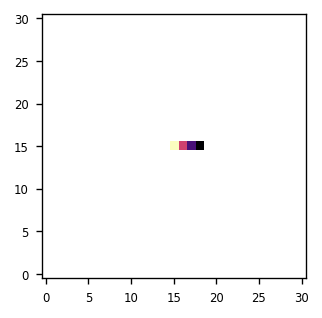

P[15]=25.60 β[19]=0.54


In [ ]:
from functools import lru_cache as cache
@cache
def prepare_kernel(p):
    Kf = make_kernel_ft(L,p,σ0)
    Λf = 1.0/Kf
    K0 = real(ifft2(Kf))
    Kh = RI(Kf).ravel()[keep]
    Λh = RI(Λf).ravel()[keep]
    sK = sum(log(Kf[keep2d]))
    nK = sum(keep2d)
    return K0,Kf,Λf,Kh,Λh,sK,nK

def HvQ0_helper(M,β,nλ,FQ,Pt,Λh):
    FM  = FA(M)
    r   = nλ * sum(FQ*FM,1)
    return FtA(nλ[:,None]*FM+r[:,None]*FQ) + β*hcm(Λh,M) + Pt@M.T@Pt

def infer(μ,Q,β,p,maxiter=100):
    K0,Kf,Λf,Kh,Λh,sK,nK = prepare_kernel(p)
    def pMμ(u): return cv(Kf/β,u).ravel()
    Mμ = op(T,pMμ)
    def pMQ(M): return trl(hcm(Kh/β,trl(M)))
    MQ = op(Rlt,pMQ)
    for i in range(maxiter):
        # Precompute shared intermediate expressions
        Q  = tril(Q)
        FQ = FA(Q)
        Pt = ltinv(Q).T
        vc = sum(FQ**2,1)/2
        nλ = n*exp(μ+vc+μ0)
        # Gradient and hessian for μ
        J  = nλ - n*y + cv(β*Λf,μ)
        def hcvμ(u): return (nλ*u + cv(β*Λf,u)).ravel()
        Hv = op(T,hcvμ)
        # Solve Newton update for μ
        Δ  = minres(Hv,J,M=Mμ,tol=mintol)[0]
        μ -= Δ
        εμ = max(abs(Δ))
        # Recompute firing rate for update μ;
        nλ = n*exp(μ+μ0+vc)
        # Gradient and Hessian for Q
        J  = trl(hcm(β*Λh,Q) + FtA(nλ[:,None]*FQ) - Pt)
        def hcvM(M): return trl(HvQ0_helper(trl(M),β,nλ,FQ,Pt,Λh)) 
        Hv = op(Rlt,hcvM)
        # Solve Newton update for Q
        Δ  = trl(minres(Hv,J,M=MQ,tol=mintol)[0])
        Q -= Δ
        εQ = max(abs(Δ))
        # Return if converged
        if εμ<tol and εQ<tol: break
    return μ,Q,i

def loss(μ,Q,β,p):
    K0,Kf,Λf,Kh,Λh,sK,nK = prepare_kernel(p)
    Q  = tril(Q)
    FQ = FA(Q)
    λ  = exp(μ+μ0+sum(FQ**2,1)/2)
    return  n@(λ-y*μ) + μ.T@cv(β*Λf,μ)/2 + (sK-nK*log(β))/2 - sum(slog(diag(Q))) +  β*sum(FQ*cm(Λf,FQ))/2

def infer_and_get_loss(μ,Q,β,p):
    μ,Q,_ = infer(μ,Q,β,p)
    return μ,Q,loss(μ,Q,β,p)


μ  = lλf.ravel()
μ0 = lλb.ravel()
Q  = eye(R)

ip = NP//2
iβ = Nβ//2
p  = Ps[ip]
β  = βs[iβ]

μ,Q,l = infer_and_get_loss(μ,Q,β,float(p))
print('\tβ[%d] ='%iβ,β,'\tloss = ',l)
μref,Qref = μ,Q
results = np0.empty((NP,Nβ),dtype='object')
    
def current_best():
    global results
    losses  = array([inf if r is None else r[2] for r in results.ravel()])
    bestidx = argmin(losses)
    bestP,bestβ = unravel_index(bestidx,results.shape)
    return bestP, bestβ, losses[bestidx]    
    
from IPython.display import clear_output
    
def search(ip,iβ):
    global results
    print('P[%d]=%0.2f β[%d]=%0.2f'%(ip,Ps[ip],iβ,βs[iβ]))
    if iβ<0 or ip<0 or iβ>=Nβ or ip>=NP: return None
    if results[ip,iβ]: return results[ip,iβ]
    # Extrapolate when possible
    if iβ+2<Nβ and results[ip,iβ+1] and results[ip,iβ+2]:
        (μ1,Q1),(μ2,Q2) = results[ip,iβ+1][:2], results[ip,iβ+2][:2]
        μ = μ1 + μ1 - μ2
        Q = Q1 + Q1 - Q2
    elif iβ>=2 and results[ip,iβ-1] and results[ip,iβ-2]:
        (μ1,Q1),(μ2,Q2) = results[ip,iβ-1][:2], results[ip,iβ-2][:2]
        μ = μ1 + μ1 - μ2
        Q = Q1 + Q1 - Q2
    elif iβ+1<Nβ and results[ip,iβ+1]: μ,Q = results[ip,iβ+1][:2]
    elif iβ>=1   and results[ip,iβ-1]: μ,Q = results[ip,iβ-1][:2]
    elif ip+1<NP and results[ip+1,iβ]: μ,Q = results[ip+1,iβ][:2]
    elif ip>=1   and results[ip-1,iβ]: μ,Q = results[ip-1,iβ][:2]
    else: μ,Q = μref,Qref
    β = βs[iβ]
    μ,Q,l = infer_and_get_loss(μ,Q,β,float(p))
    results[ip,iβ] = (μ,Q,l)
    print('P[%d]=%0.2f β[%d]=%0.2f loss=%f'%(ip,Ps[ip],iβ,βs[iβ],l))
    clear_output(wait=True)
    figure()
    imshow(array([r[2] if not r is None else nan for r in results.ravel()]).reshape(NP,Nβ))
    show()
    search_order = [(0,1),(0,-1),(1,0),(-1,0),(1,1),(1,-1),(-1,1),(-1,-1)]
    for Δp,Δβ in search_order:
        if current_best()[:2]!=(ip,iβ): break
        search(ip+Δp,iβ+Δβ)
    return results[ip,iβ]

ip = NP//2
iβ = Nβ//2
search(ip,iβ)